<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

## <span style="color:red "> 接下來讓我們把手續費和證券交易稅的因素考慮進來，繼續給它Back trade一下吧!
---
    
   ### [參考連結](https://www.cmoney.tw/learn/course/cmoney/topic/152)
---
   ### [你知道有最低手續費嗎?](https://davidhuang1219.pixnet.net/blog/post/325170441)

## <span style="color:red ">  <策略1-with Commision>先用SAM，來做個簡單的回測策略吧!
---
### 先回想一下，你還記的20-day SMA是什麼意思嗎?
    
    我們測定策略如下:
    1.如果今天的收盤價高於20-day SMA，那我們就買進一股的股票。
    2.如果今天的收盤價低於20-day SMA，那我們就賣掉一股的股票。
    3.任何時候，我們手上最多就一股股票。
    
    

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [2]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell()


### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [3]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [4]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [5]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcash(cash)

#綠色是可以改的
#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>最興奮的時刻來了!-開始回測

In [6]:
# run backtest
print(f'起始資產總值: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'最終資產總值: {cerebro.broker.getvalue():.2f}')

起始資產總值: 1000.00
2022-05-18, 開出買單 --- 當時市場價格: 538.00
2022-05-19, 買單執行 --- 買價: 523.00, 成本: 523.00, 手續費: 1.00
2022-05-19, 開出賣單 --- 當時市場價格: 522.00
2022-05-20, 賣單執行 --- 賣價: 524.00, 成本: 523.00, 手續費: 2.57
2022-05-20, 運作結果 --- 獲利狀況: 1.00, 淨獲利: -2.57
2022-05-20, 開出買單 --- 當時市場價格: 530.00
2022-05-23, 買單執行 --- 買價: 533.00, 成本: 533.00, 手續費: 1.00
2022-05-23, 開出賣單 --- 當時市場價格: 528.00
2022-05-24, 賣單執行 --- 賣價: 530.00, 成本: 533.00, 手續費: 2.59
2022-05-24, 運作結果 --- 獲利狀況: -3.00, 淨獲利: -6.59
2022-05-27, 開出買單 --- 當時市場價格: 530.00
2022-05-30, 買單執行 --- 買價: 538.00, 成本: 538.00, 手續費: 1.00
2022-06-10, 開出賣單 --- 當時市場價格: 530.00
2022-06-13, 賣單執行 --- 賣價: 518.00, 成本: 538.00, 手續費: 2.55
2022-06-13, 運作結果 --- 獲利狀況: -20.00, 淨獲利: -23.55
2022-07-14, 開出買單 --- 當時市場價格: 475.00
2022-07-15, 買單執行 --- 買價: 481.00, 成本: 481.00, 手續費: 1.00
2022-08-23, 開出賣單 --- 當時市場價格: 504.00
2022-08-24, 賣單執行 --- 賣價: 504.00, 成本: 481.00, 手續費: 2.51
2022-08-24, 運作結果 --- 獲利狀況: 23.00, 淨獲利: 19.49
2022-08-26, 開出買單 --- 當時市場價格: 512.00
2022-08-29, 買單執行 --- 買價: 497.00, 成本: 49

### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


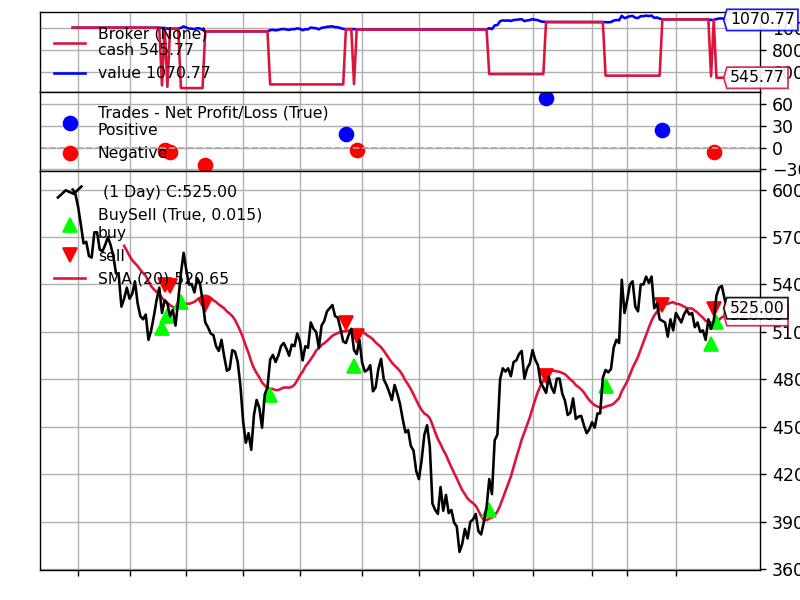

[[<Figure size 640x480 with 3 Axes>]]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']=100
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red ">如果你有跑不出圖的問題

In [ ]:
#如果你有跑不出圖的問題
!pip uninstall matplotlib  

In [ ]:
!pip install matplotlib==3.2.2

### <span style="color:red "><策略2- with Commision>我們不得不懷疑20-day SMA是一個好選擇嗎?
--------
    你有想過一個問題?幾日均線說穿了都是人說的一個故事。那既然是人定的，為何不讓機器來告訴我，屬於台積電的財富均線應該是幾日比較好呢?

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [8]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()

    def stop(self):
        self.log(f'(SMA週期設定 = {self.params.ma_period:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')


### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [9]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision >建立回測分析「大腦」

In [10]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(SmaStrategy, ma_period=range(5, 61))
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)



### <span style="color:red "><策略2.6- with Commision>最興奮的時刻來了!-開始回測

In [11]:
# win系統下，請固定用單核去跑。其他系統可以試試看多核
cerebro.run(maxcpus=1)


2023-03-28, (SMA週期設定 =  5) --- 淨利數值: -212.10
2023-03-28, (SMA週期設定 =  6) --- 淨利數值: -111.21
2023-03-28, (SMA週期設定 =  7) --- 淨利數值: -86.32
2023-03-28, (SMA週期設定 =  8) --- 淨利數值: -111.85
2023-03-28, (SMA週期設定 =  9) --- 淨利數值: -53.74
2023-03-28, (SMA週期設定 = 10) --- 淨利數值: -53.87
2023-03-28, (SMA週期設定 = 11) --- 淨利數值: -21.96
2023-03-28, (SMA週期設定 = 12) --- 淨利數值: 16.08
2023-03-28, (SMA週期設定 = 13) --- 淨利數值: 37.28
2023-03-28, (SMA週期設定 = 14) --- 淨利數值: 37.28
2023-03-28, (SMA週期設定 = 15) --- 淨利數值: 30.21
2023-03-28, (SMA週期設定 = 16) --- 淨利數值: 17.23
2023-03-28, (SMA週期設定 = 17) --- 淨利數值: 45.51
2023-03-28, (SMA週期設定 = 18) --- 淨利數值: 55.10
2023-03-28, (SMA週期設定 = 19) --- 淨利數值: 59.25
2023-03-28, (SMA週期設定 = 20) --- 淨利數值: 70.77
2023-03-28, (SMA週期設定 = 21) --- 淨利數值: 62.86
2023-03-28, (SMA週期設定 = 22) --- 淨利數值: 64.47
2023-03-28, (SMA週期設定 = 23) --- 淨利數值: 65.47
2023-03-28, (SMA週期設定 = 24) --- 淨利數值: 55.01
2023-03-28, (SMA週期設定 = 25) --- 淨利數值: 26.64
2023-03-28, (SMA週期設定 = 26) --- 淨利數值: 43.59
2023-03-28, (SMA週期設定 = 27) --- 淨利數值: 8.92
20

[[<backtrader.cerebro.OptReturn at 0x18cb23c3dc0>],

### <span style="color:red "><策略3- with Commision>技術分析不是一直說什麼黃金交叉...什麼死亡交叉...
-----
    1.黃金交叉：短天期均線向上與長天期交叉，稱為黃金交叉。
    2.死亡交叉：短天期均線向下與長天期交叉，稱為死亡交叉。

### <span style="color:red "><策略3.2- with Commision>建立交易策略

In [17]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=7,   # 短期均線週期
        pslow=67   # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.crossover < 0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell()
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 最終資產價值: {self.broker.getvalue():.2f}')

### <span style="color:red "><策略3.4- with Commision>建立台股交易費用計算模式

In [18]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略3.5- with Commision>建立回測分析「大腦」

In [19]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)



### <span style="color:red "><策略3.6- with Commision>最興奮的時刻來了!-開始回測

In [20]:
# run backtest
print(f'起始資產總值: {cerebro.broker.getvalue():.2f}')
cerebro.run()

起始資產總值: 1000.00
2022-08-09, 開出買單 --- 當時市場價格: 510.00
2022-08-10, 買單執行 --- 買價: 500.00, 成本: 500.00, 手續費: 1.00
2022-09-02, 開出賣單 --- 當時市場價格: 485.00
2022-09-02, (SMA週期設定 = 短週期: 7,長週期:67) --- 最終資產價值: 984.00


### <span style="color:red "><策略3.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


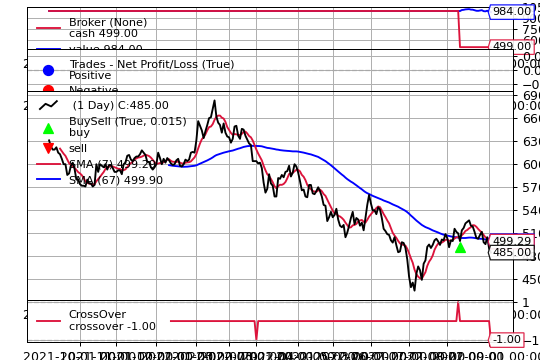

[[<Figure size 432x288 with 4 Axes>]]

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略4- with Commision>上面是5日線和10日線的交叉結果，那如果我想要知道哪兩條線的配對交叉結果最好...
-----
###     我就是想知道:
        到底是MA5穿過MA20比較厲害?
        還是MA20穿出MA60比較厲害?

### <span style="color:red "><策略4.2- with Commision>建立交易策略

In [16]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=5,   # 短期均線週期
        pslow=10   # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.price = order.executed.price
                self.comm = order.executed.comm

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return


    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.order = self.buy()
        else:
            # sell condition
            if self.crossover < 0:
                self.order = self.sell()
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')

### <span style="color:red "><策略4.4- with Commision>建立台股交易費用計算模式

In [17]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略4.5- with Commision>建立回測分析「大腦」

In [15]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
cerebro.optstrategy(SmaCross, pfast=[5,7,8,9,10,12,15,17,20],pslow=[21,22,23,24,25,27,30,32,35,37,40,42,45,47,50,52,55,57,60,62,65,67,70])
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)


In [18]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
cerebro.optstrategy(SmaCross, pfast=range(5,21),pslow=range(25,61))
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略4.6- with Commision>最興奮的時刻來了!-開始回測

In [19]:
# win系統下，請固定用單核去跑。其他系統可以試試看多核
cerebro.run(maxcpus=1)


2023-02-19, (SMA週期設定 = 短週期: 5,長週期:25) --- 淨利數值: -37.62
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:26) --- 淨利數值: 4.54
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:27) --- 淨利數值: -5.44
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:28) --- 淨利數值: -12.41
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:29) --- 淨利數值: -7.41
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:30) --- 淨利數值: -12.40
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:31) --- 淨利數值: -12.40
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:32) --- 淨利數值: 0.08
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:33) --- 淨利數值: -8.92
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:34) --- 淨利數值: -14.40
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:35) --- 淨利數值: -23.37
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:36) --- 淨利數值: -20.38
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:37) --- 淨利數值: -41.85
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:38) --- 淨利數值: -61.35
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:39) --- 淨利數值: -53.86
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:40) --- 淨利數值: -53.86
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:41) --- 淨利數值: -47.36
2023-02-19, (SMA週期設定 = 短週期: 5,長週期:42) --- 淨利數值: -54.34
2023-02-19, (SMA週

2023-02-19, (SMA週期設定 = 短週期: 9,長週期:32) --- 淨利數值: -44.88
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:33) --- 淨利數值: -54.84
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:34) --- 淨利數值: -84.82
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:35) --- 淨利數值: -88.82
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:36) --- 淨利數值: -61.88
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:37) --- 淨利數值: -61.88
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:38) --- 淨利數值: -70.85
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:39) --- 淨利數值: -85.85
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:40) --- 淨利數值: -90.81
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:41) --- 淨利數值: -87.32
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:42) --- 淨利數值: -78.32
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:43) --- 淨利數值: -67.35
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:44) --- 淨利數值: -76.82
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:45) --- 淨利數值: -85.79
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:46) --- 淨利數值: -92.78
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:47) --- 淨利數值: -77.29
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:48) --- 淨利數值: -50.77
2023-02-19, (SMA週期設定 = 短週期: 9,長週期:49) --- 淨利數值: -51.30
2023-02-19

KeyboardInterrupt: 